In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Задача Коши для уравнения второго порядка
$u''(x)=f(x,u,u')$  
$f(x,u,u') = g(x) + {a_1(x)}\cdot{u(x)} + a_2(x)\cdot{u'(x)}$  
$u(0) = u_0$  
$u'(0) = u_1$

In [2]:
class Diff_equation:
    def __init__(self,f,interval,ics,x0=0):
        self.f = f
        self.a, self.b = interval
        self.u0, self.u1 = ics
        self.x0 = x0
        
    def euler(self,h,n):
        values = []
        x = self.x0
        u = self.u0
        u_deriv = self.u1
        values.append((x,u,u_deriv))
        
        for i in range(1,n+1):            
            u_deriv += h * self.f(x,u,u_deriv)
            u += h * u_deriv
            x += h
            values.append((x,u,u_deriv))
        
        return np.array(values)
    
    def rk4(self,h,n):
        values = []
        x = self.x0
        u = self.u0
        u_deriv = self.u1
        values.append((x,u,u_deriv))
        
        for i in range(1,n+1):
            k1 = self.f(x,u,u_deriv)
            m1 = u_deriv
            k2 = self.f(x + h/2, u + h/2 * m1, u_deriv + h/2 * k1)
            m2 = u_deriv + h/2 * k1
            k3 = self.f(x + h/2, u + h/2 * m2, u_deriv + h/2 * k2)
            m3 = u_deriv + h/2 * k2
            k4 = self.f(x + h, u + h * m3, u_deriv + h * k3)
            m4 = u_deriv + h * k3
            
            u_deriv += h / 6 * (k1 + 2*k2 + 2*k3 + k4)
            u += h/6 * (m1 + 2*m2 + 2*m3 + m4)
            x += h
            values.append((x,u,u_deriv))
        
        return np.array(values)
    
    def adams(self,h,n):
        values = []
        x = self.x0
        u_2 = self.u0
        u_deriv_2 = self.u1
        
        _, u_1, u_deriv_1 = self.rk4(h,1)[-1]
        _, u, u_deriv = self.rk4(h,2)[-1]
        
        values.append((x, u_2, u_deriv_2))
        values.append((x + h, u_1, u_deriv_1))
        values.append((x + 2*h, u, u_deriv))
        x += 2*h
        
        for i in range(3,n+1):
            k1 = self.f(x, u, u_deriv)
            k2 = self.f(x - h, u_1, u_deriv_1)
            k3 = self.f(x - 2*h, u_2, u_deriv_2)
            m1 = u_deriv
            m2 = u_deriv_1
            m3 = u_deriv_2
            
            u_deriv_2 = u_deriv_1
            u_deriv_1 = u_deriv
            u_deriv += h/12 * (23*k1 - 16 * k2 + 5* k3)
            
            u_2 = u_1
            u_1 = u
            u += h/12 * (23*m1 - 16*m2 + 5*m3)
            x+=h
            
            values.append((x,u,u_deriv))
        
        return np.array(values)
            
    

In [3]:
def f(x,u,u_deriv):
    return -np.tanh(x/2)*u_deriv + np.cos(x)*u - np.sin(x) - 1/2*np.sin(2*x)

def true_u(x):
    return np.sin(x) + np.tanh(x/2)

def true_u_deriv(x):
    return np.cos(x) + 1/2 * 1/(np.cosh(x/2) ** 2)

u0, u1 = 0, 1.5
a,b = 0,1
de = Diff_equation(f=f,interval=(a,b),ics=(u0,u1))

In [4]:
def compute_errors(values):
    errors = [abs(values[i][1] - true_u(x)) for i,x in enumerate(values[:,0])]
    return errors

In [5]:
def runge_rule(de,h,n,method):
    if method == 'rk4':
        values1 = de.rk4(h,n)
        values2 = de.rk4(2*h,n//2)
        p = 4
    elif method == 'euler':
        values1 = de.euler(h,n)
        values2 = de.euler(2*h,n//2)
        p = 1
    elif method == 'adams':
        values1 = de.adams(h,n)
        values2 = de.adams(2*h,n//2)        
        p = 3
    correction = (values1[::2,1] - values2[:,1]) / (2**p - 1)
    new_values = values1[::2,1] + correction
    return np.c_[values1[::2,0],new_values]

In [10]:
def plot_error():
    plt.figure(figsize=(10,6))
    errors1 = []
    errors2 = []
    for n in range(10,1000):
        max_error1 = max(compute_errors(runge_rule(de,1/n,n,'rk4')))
        errors1.append(max_error1)
        max_error2 = max(compute_errors(de.rk4(1/n,n)))
        errors2.append(max_error2)
    plt.plot(np.log(1/np.arange(10,1000)), np.log(errors1),label='adams_runge')
    plt.plot(np.log(1/np.arange(10,1000)), np.log(errors2),label='adams')
    plt.legend()

In [11]:
n=100
compute_errors(runge_rule(de,1/n,n,'adams'))

[0.0,
 1.5079604231971189e-12,
 3.757562039297113e-10,
 8.987008498495541e-10,
 1.1856843007418405e-09,
 1.5795690588848998e-09,
 1.972623758783598e-09,
 2.3651564595716934e-09,
 2.7568350657869445e-09,
 3.1475988482299044e-09,
 3.537323489677391e-09,
 3.925894664913443e-09,
 4.313199797323364e-09,
 4.699128863805413e-09,
 5.083574117215051e-09,
 5.466430474942996e-09,
 5.84759562993753e-09,
 6.226970161726797e-09,
 6.604457647441109e-09,
 6.979964717324094e-09,
 7.353401443310759e-09,
 7.724680672893669e-09,
 8.093718695256769e-09,
 8.460435130253074e-09,
 8.82475303942698e-09,
 9.186598370902743e-09,
 9.5459006255183e-09,
 9.902591857624543e-09,
 1.0256608007352952e-08,
 1.060788745732566e-08,
 1.0956371587766967e-08,
 1.1302004332414128e-08,
 1.1644732511584266e-08,
 1.1984505166040549e-08,
 1.2321273445969894e-08,
 1.265499138813908e-08,
 1.298561391749331e-08,
 1.3313097735334622e-08,
 1.3637401874433408e-08,
 1.3958486144716176e-08,
 1.4276311022243249e-08,
 1.459083831534258e-08

In [12]:
compute_errors(de.adams(1/n,n))

[0.0,
 6.597136031905038e-13,
 1.3192780201620735e-12,
 7.908933230549309e-11,
 3.2351155782039953e-10,
 6.56891679939875e-10,
 1.1026259350011003e-09,
 1.6606064578983393e-09,
 2.330742626677207e-09,
 3.1129114286265747e-09,
 4.006975723447326e-09,
 5.012780218693891e-09,
 6.130152135908062e-09,
 7.358901044085542e-09,
 8.698819137231695e-09,
 1.0149681040072522e-08,
 1.1711244141121568e-08,
 1.3383248453902041e-08,
 1.5165416811235843e-08,
 1.7057454892999147e-08,
 1.9059051392655846e-08,
 2.1169877906235257e-08,
 2.3389589376421327e-08,
 2.5717823703974574e-08,
 2.8154202413865903e-08,
 3.06983302111874e-08,
 3.334979564728613e-08,
 3.6108170675674955e-08,
 3.897301104061057e-08,
 4.1943856721182726e-08,
 4.502023120966925e-08,
 4.820164267727023e-08,
 5.1487583252463054e-08,
 5.4877529631625066e-08,
 5.837094285698896e-08,
 6.19672688717543e-08,
 6.566593857559866e-08,
 6.946636754712188e-08,
 7.336795648793526e-08,
 7.73700916667508e-08,
 8.147214447529194e-08,
 8.567347187238283e

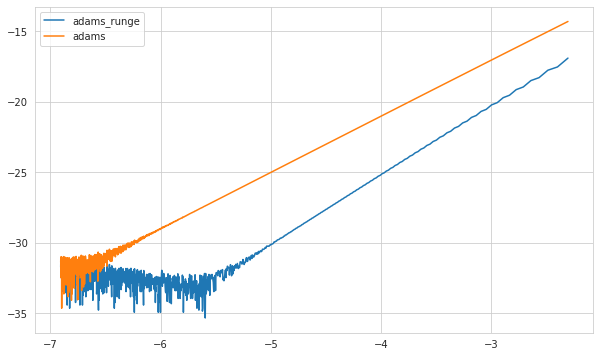

In [13]:
plot_error()